# COGS 118A - Final Project

### Installing dependencies and importing packages

In [3]:
import numpy as np # for matrix processing
import pandas as pd # for dataframe processing
import matplotlib.pyplot as plt # for plot
from wordcloud import WordCloud, STOPWORDS # for word cloud generator and tag cloud creator
import re
import nltk
# nltk.download('stopwords') # if not yet download the stopwords
stemmer = nltk.SnowballStemmer("english")
# "stopwords" are the most common words in a language that are filtered out before processing
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

# Names

Hopefully your team is at least this good. Obviously you should replace these with your names.

- Jason Krentsel
- Jackie Lai
- Shantelle Serafin
- Zecheng (Justin) Li

# Abstract 

Our goal is to categorize text found within tweets as hate speech, offensive language, or being neither. The data set we are using is representative of actual tweets on twitter and are measured by crowd-sourced opinions of which category best fits each tweet. We will be using this data to train an algorithm to determine if tweets contain hate speech and/or offensive language to then determine if it would be appropriate to flag the tweet or ban the user. Performance will be measured based on accuracy of classification.

# Background

Offensive speech and hate speech is prolific on the internet, one could argue that it is more easily found there than in the real world. This abundance could be due to a number of factors, including but not limited to anonymity, invisibility, community, and instantaneousness<a name="brown"></a>[<sup>[1]</sup>](#brownnote). Because of the anonymity and real physical distance between speaker and recipient, the internet has become a place where it is safe, and sometimes even encouraged, to engage in hate culture as there are much fewer real-world repercussions. Resultantly, social media companies are facing lots of criticism and backlash from governments, causing them to be more “proactive in anticipating corrupted use of their online platforms.” <a name="ulgen"></a>[<sup>[2]</sup>](#ulgennote) However, the “constantly evolving nature of and variety of cyberhate”<a name="brown"></a>[<sup>[1]</sup>](#brownnote) makes this not only practically difficult but could potentially lead to misflagging of tweets or accounts.

# Problem Statement

The problem we are solving is the classification of Tweets into 2 or 3 different categories: hate speech, offensive language, or neither. We want to develop a machine learning model that can accurately predict a novel tweets class for possible use in automatically moderating the site. One of the more complex parts of creating such a model is turning text into quantitative data. While this is far from impossible, there are many natural language processing techniques we can utilize which can maintain varying amounts of semantic information. After tokenizing a tweet, we can use a Term Frequency-Inverse Document Frequency (TF-IDF) strategy to generate a value of how important each word is to a tweet. This is quite a powerful technique because not all offensive tweets are hateful. For example, “I f***ing love this movie” would obviously be flagged for offensive language, but the importance of the offensive word is low and could signify non-hateful meaning. On the other hand, hateful language doesn’t necessarily have to have offensive content, ex. “I think the director of this movie should never show their face in public after that terrible movie”. The main error metric we want to use is false positive rate. As this would be an automatic moderating system, we want to only allow it to ban users only when it is very sure that their tweets are offensive or hateful. We can use a more lenient system for flagging tweets for human moderation where our model might miss, but it would not be good for it to accidentally ban users that did not post malicious content. Malicious text content on the internet is arguably some of the most replicable data there can be. There is a constant flow of tweets being published, and even when they are not neatly organized in a dataset, we can always utilize Twitter’s API to scrape for more data.

# Data

- https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
- 24784 observations, with 7 variables
- An observation consists of [count of human classifier votes, hate speech votes, offensive language votes, neither votes, final classification (plural vote), tweet text]
- The main critical variables is the final classification and the raw tweet text
- We will need to use various natural language processing techniques to turn the raw tweet text into quantifiable values. We will most likely utilize bag-of-words and Term Frequency-Inverse Document Frequency to convert this text data into numerical values.


In [4]:
df = pd.read_csv('labeled_data.csv')
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
df['class'].unique()

array([2, 1, 0], dtype=int64)

Class label for majority of CF users:
 0 - hate speech
 1 - offensive language
 2 - neither

In [6]:
df[['tweet', 'class']]

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,"you've gone and broke the wrong heart baby, an...",2
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


In [7]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

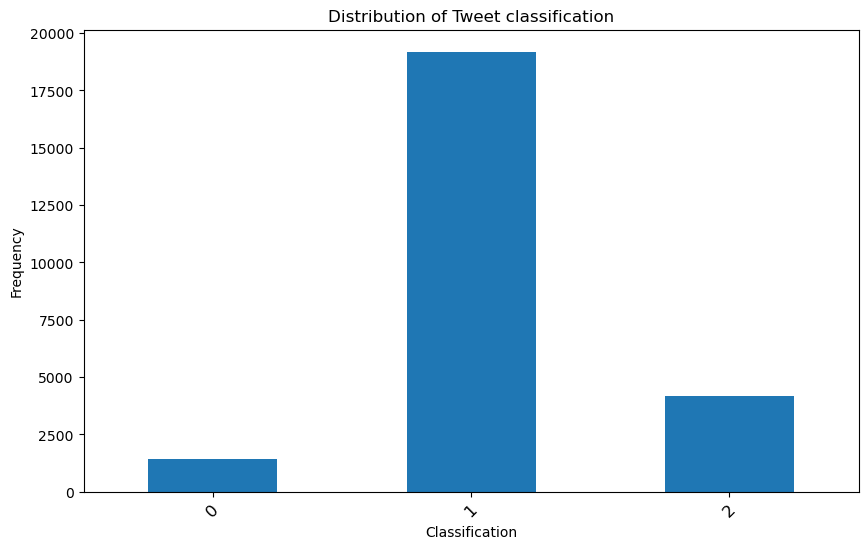

In [8]:
class_dis = df['class'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
class_dis.plot(kind='bar')
plt.title('Distribution of Tweet classification')
plt.xlabel('Classification')
plt.xticks(fontsize=12, rotation=45)
plt.ylabel('Frequency')
plt.show()

### Data description
It’s important to note that the data we have has a large imbalance of tweet labels between hate speech (0), offensive language (1), and neither (2). The majority of the data is labeled 1. Thus, this may cause the model to have a bias to classify a tweet as offensive. In order to combat this challenge, we plant split the data evenly during training to ensure that the model is not biased towards one classification. Moreover, we may consider enlargement for the 0 and 2 classes. In the cells below we generated word clouds to showcase the most common words in each class.

In [9]:
def generate_wordcloud(tweets):
    # Join all the tweets together into one long string
    long_string = ' '.join(tweets)
    # set stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("RT")

    # Create a WordCloud object
    wordcloud = WordCloud(width = 800, height = 400,
                          background_color ='white',
                          stopwords = stopwords,
                          min_font_size = 10).generate(long_string)

    # Plotting the WordCloud
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

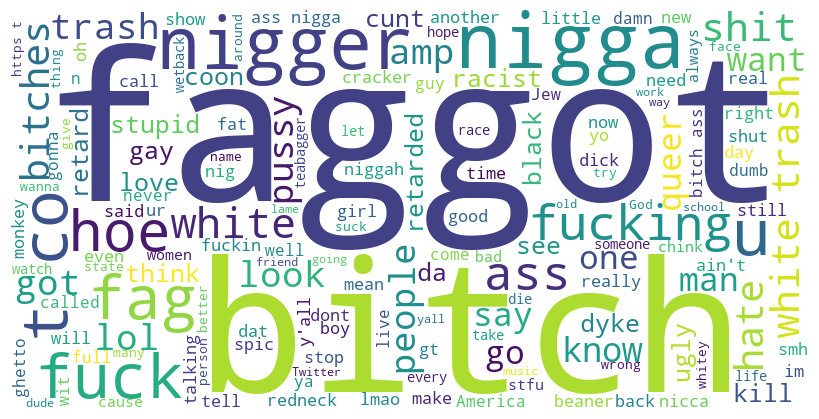

In [10]:
generate_wordcloud(df[df['class'] == 0]['tweet'])

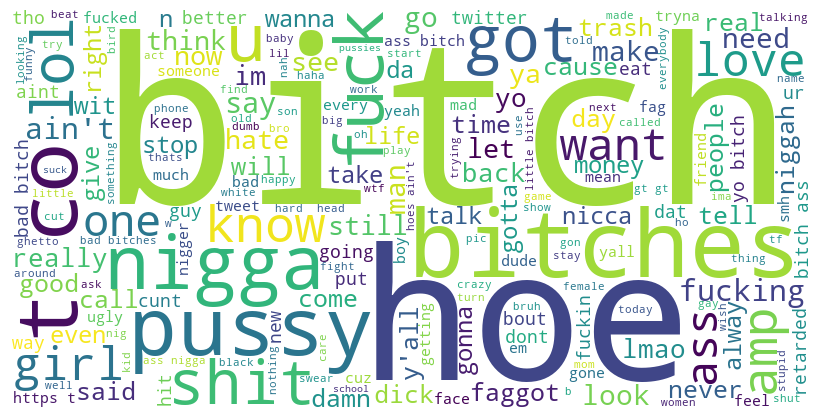

In [11]:
generate_wordcloud(df[df['class'] == 1]['tweet'])

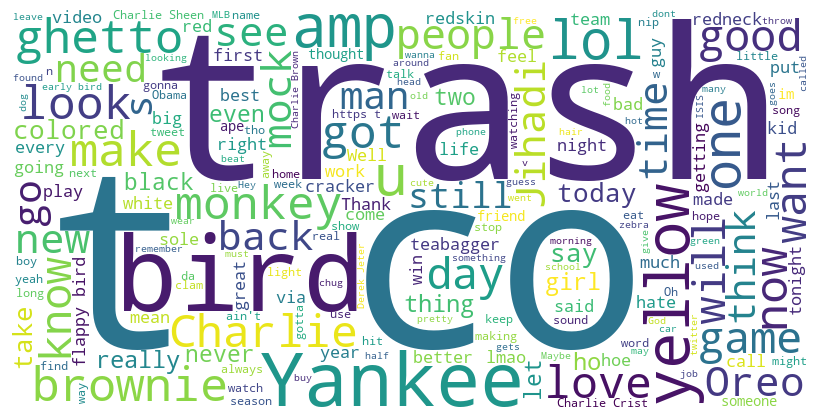

In [12]:
generate_wordcloud(df[df['class'] == 2]['tweet'])

In [13]:
df[df['class'] == 0]['tweet']

85       "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...
89       "@CB_Baby24: @white_thunduh alsarabsss" hes a ...
110      "@DevilGrimz: @VigxRArts you're fucking gay, b...
184      "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...
202      "@NoChillPaz: "At least I'm not a nigger" http...
                               ...                        
24576                  this guy is the biggest faggot omfg
24685    which one of these names is more offensive kik...
24751           you a pussy ass nigga and I know it nigga.
24776                                   you're all niggers
24777    you're such a retard i hope you get type 2 dia...
Name: tweet, Length: 1430, dtype: object

### Data Cleaning
Using this function, we will "clean" the contents of each tweet for easier classification. First, we'll make all text lowercase for consistency and to avoid any issues case difference may cause. Then, we remove extraneous text, or text that generally hold little to no information for our purposes. These can include html tags, urls, usernames, punctuation, newline characters, digits and words with digits. We do recognize, however, that removing digits and words containing digits may cause problems in real time since some combinations of digits may hold meaning. After, we apply stemming, which reduces each word to its root form, for simplicity and return the cleaned tweet. 

In [23]:
# refer to the help of kaggle
def clean_text(text):
    # Convert all text to lower case. This is to maintain uniformity and avoid duplicacy over case difference.
    text = str(text).lower()

    # Remove text inside square brackets. This can help get rid of any unwated data enclosed in these brackets.
    text = re.sub('\[.*?\]', '', text)

    # Remove urls. URLs are usually not informative in text classification tasks.
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove html tags. Again, they carry less to no information for text classification.
    text = re.sub('<.*?>+', '', text)

    # Remove punctuations. This will help us reduce the complexity of data and the size of the vocabulary.
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Replace newline characters with space. For text analysis, we usually treat text data as a single line.
    text = re.sub('\n', '', text)

    # Remove digits and words containing digits. We are assuming here that digits do not carry any sentiment.
    # But in real time, it might be a problem since some combinations of digits might have meanings.
    text = re.sub('\w*\d\w*', '', text)

    # Remove usernames and tagged users. We assume the username holds no sentiment.
    text = re.sub('@*[\w_]', '', text)

    # Remove stopwords. Stop words are commonly used words that are less informative and are usually removed.
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)

    # Apply stemming. Stemming is the process of reducing a word to its word stem, base or root form.
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)

    # Return the cleaned text
    return text


In [24]:
tweets = df['tweet']
tweet_class = df['class']

tweet_class = np.where(tweet_class == 0, 1, tweet_class)
tweet_class = np.where(tweet_class == 2, 0, tweet_class)

# data preprocessing
tweets = df['tweet'].apply(clean_text)

X = tweets
Y = tweet_class

# Proposed Solution

In this section, clearly describe a solution to the problem. The solution should be applicable to the project domain and appropriate for the dataset(s) or input(s) given. Provide enough detail (e.g., algorithmic description and/or theoretical properties) to convince us that your solution is applicable. Make sure to describe how the solution will be tested.  

If you know details already, describe how (e.g., library used, function calls) you plan to implement the solution in a way that is reproducible.

If it is appropriate to the problem statement, describe a benchmark model<a name="sota"></a>[<sup>[3]</sup>](#sotanote) against which your solution will be compared. 

# Evaluation Metrics

In the context of our problem statement, precision is an essential metric because we are highly concerned about minimizing false positives. In this case, a false positive would mean our model wrongly classifies a tweet as hate speech or offensive language, potentially leading to an undeserved ban or flag for the user. This could have significant consequences for the user experience and the overall trust in the platform. Therefore, we aim to maximize the precision of our model.

### Precision

Precision, also known as the positive predictive value, quantifies the model's ability to avoid labeling non-hateful or non-offensive tweets as hateful or offensive. Mathematically, precision is defined as the ratio of true positives (TP) to the sum of true positives and false positives (FP):

Precision = TP / (TP + FP)

Where:
- TP = True Positives: The instances where the model correctly predicted a tweet as hate speech or offensive language.
- FP = False Positives: The instances where the model incorrectly flagged a non-offensive tweet as offensive or hate speech.

The higher the precision, the lower the false positive rate, and the fewer innocent users will get flagged or banned.

For instance, if our model flags 100 tweets as offensive, and 85 of them are indeed offensive, the precision of our model would be 85/100 = 0.85 or 85%. This implies that 85% of the users flagged by the system as offensive were correctly identified.

However, precision alone may not provide the full picture of our model's performance. It does not consider false negatives (actual offensive tweets that the model failed to flag), which are also a concern. To get a more comprehensive understanding, we might consider other metrics like recall or F1 score in conjunction with precision. But given our specific objective of reducing user banning due to misclassification, precision becomes our primary metric.

Thus, while building the model, we aim to maximize precision to ensure that the users are not wrongly flagged or banned due to the misclassification of their tweets as hate speech or offensive language.


# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

Quick Description of what we did using logistic regression, copy from checkpoint and reduce size

### Subsection 2

Implement SVM, possible CV for hyper paremeters, show the process and results

### Subsection 3

NN, possible use of CV for hyperparmams, results

### Subsection 4

Possible changes to how we manipulate our data?



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

FILL here

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?

FILL here

### Ethics & Privacy

Considering that we are going to classify whether or not a tweet is hateful or offensive, there may be ethical concerns. Firstly, if the classifier were to perform inaccurately it can cause harm to many people. For example, if it classifies a tweet that is not hateful as hateful, then it can impede on someone's freedom of speech. Second, if it classifies a tweet that is hateful that is not hateful, it can damage a person's mental wellbeing. Our team plans to prioritize reducing misses over false alarms in order to protect the mental health of the users at scale. Contrastingly, because the tweets are posted to the public we are not concerned with privacy issues. Given that our data is unevenly distributed and has more tweets that are labeled as offensive, our model may be biased toward offensive classifications. This may over classify non-offensive tweets and limit freedom of speech. We are planning to divide the data evenly during training and testing and potentially enlarge the minority classes to minimize bias.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

FILL here

# Footnotes
<a name="brownnote"></a>1.[^](#brown): Brown, Alexander. “What Is so Special about Online (as Compared to Offline) Hate Speech?” Ethnicities, vol. 18, no. 3, 2018, pp. 297–326. JSTOR, https://www.jstor.org/stable/26497929. Accessed 18 May 2023. <br>
<a name="ulgennote"></a>2.[^](#ulgen): Ülgen, Sinan. “FREEDOM OF EXPRESSION ONLINE.” GOVERNING CYBERSPACE: A Road Map for Transatlantic Leadership, Carnegie Endowment for International Peace, 2016, pp. 17–28. JSTOR, http://www.jstor.org/stable/resrep26924.7. Accessed 18 May 2023.<br>
<a name="chatgptnote"></a>3.[^](#chatgpt): ChatGPT, OpenAI. Personal communication for technical assistance, formatting, and provision of sample code. May 2023.
